This notebook is to investigate the value of NFSIC as a function of the two test location $v$ and $w$.

In [12]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
#%config InlineBackend.figure_format = 'pdf'
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import fsic.util as util
import fsic.data as data
import fsic.kernel as kernel
import fsic.indtest as it
import scipy.stats as stats


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# font options
font = {
    #'family' : 'normal',
    #'weight' : 'bold',
    'size'   : 16
}

plt.rc('font', **font)
plt.rc('lines', linewidth=2)
#matplotlib.rc('text', usetex=True)
#matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

In [14]:
def get_med_kernels(X, Y):
    """Return kernels k and l by computing the median heuristic 
    for X, and Y."""    
    # data and parameters
    medx2 = util.meddistance(X)**2
    medy2 = util.meddistance(Y)**2
    # print
    print('med x: %.3f'%medx2**0.5)
    print('med y: %.3f'%medy2**0.5)
    k = kernel.KGauss(medx2)
    l = kernel.KGauss(medy2)
    return k, l


In [15]:
def nfsic_stat(pdata, k, l, V, W, reg=0):
    nfsic = it.NFSIC(k, l, V, W, alpha=0.01, reg=reg)
    s = nfsic.compute_stat(pdata)
    return s

def nfsic_u(pdata, k, l, V, W, reg=0):
    X, Y = pdata.xy()
    _, u, _ = it.nfsic(X, Y, k, l, V, W, reg=reg)
    return u

def nfsic_joint_embed(pdata, k, l, V, W, reg=0):
    X, Y = pdata.xy()
    n = X.shape[0]
    J = V.shape[0]
    
    K = k.eval(X, V) # n x J
    L = l.eval(Y, W) # n x J
    # mean
    mean_k = np.mean(K, 0)
    mean_l = np.mean(L, 0)
    return np.mean(K*L, 0)
    
def nfsic_product_embeds(pdata, k, l, V, W, reg=0):
    X, Y = pdata.xy()
    n = X.shape[0]
    J = V.shape[0]
    
    K = k.eval(X, V) # n x J
    L = l.eval(Y, W) # n x J
    # mean
    mean_k = np.mean(K, 0)
    mean_l = np.mean(L, 0)
    return np.mean(K, 0)*np.mean(L, 0)
    

def nfsic_variance(pdata, k, l, V, W, reg=0):
    X, Y = pdata.xy()
    _, _, Sig = it.nfsic(X, Y, k, l, V, W, reg=reg)
    return Sig


In [16]:

def generic_contourf(pdata, k, l, func, title=None):
    """
    func: (pdata, k, l, V, W) |-> value. A function computing the values to plot.
    """
    X, Y = pdata.xy()
    max1, max2 = np.max(X, 0), np.max(Y, 0)
    min1, min2 = np.min(X, 0), np.min(Y, 0)
    #sd1, sd2 = np.std(XY, 0)
    sd1, sd2 = ((max1-min1)*0.3, (max2-min2)*0.3)
    # form a frequency grid to try 
    nd1 = 40
    nd2 = 40
    loc1_cands = np.linspace(min1-sd1/2, max1+sd1/2, nd1)
    loc2_cands = np.linspace(min2-sd2/2, max2+sd2/2, nd2)
    lloc1, lloc2 = np.meshgrid(loc1_cands, loc2_cands)
    # nd2 x nd1 x 2
    loc3d = np.dstack((lloc1, lloc2))
    # #candidates x 2
    all_loc2s = np.reshape(loc3d, (-1, 2) )

    # all_locs = #candidates x J x 2
    #all_locs = np.array( [np.vstack((c, loc1)) for c in all_loc2s] )
    
    # evaluate Lambda(T) on each candidate T on the grid. Size = (#candidates, )
    stat_grid = np.array([func(pdata, k, l, np.array([T[0]])[np.newaxis, :], 
                                     np.array([T[1]])[np.newaxis, :]) for T in all_loc2s])
    stat_grid = np.reshape(stat_grid, (nd2, nd1) )

    #ax = fig.gca(projection='3d')
    #ax.plot_surface(lloc1, lloc2, stat_grid, rstride=8, cstride=8, alpha=0.3)
    #cset = ax.contourf(lloc1, lloc2, stat_grid, zdir='z', offset=0, cmap=cm.coolwarm)
    plt.figure(figsize=(8, 3))
    plt.contourf(lloc1, lloc2, stat_grid, alpha=0.6)
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    #plt.axis('off')
    #plt.colorbar()

    max_stat = np.max(stat_grid)
    #plt.xlabel('')
    #plt.ylabel('')
    n = X.shape[0]
    if title is not None:
        pass
        #plt.title(title)
    #ax.view_init(elev=max_stat*2, azim=90)

    # plot the data
    plt.plot(X, Y, '.k', markeredgecolor='k', markersize=5, alpha=0.9)
    #plt.xlabel('$X$')
    #plt.ylabelel('$Y$')
    
    
    # return the locations V, W 
    ind2d = np.unravel_index(np.argmax(stat_grid), stat_grid.shape)
    V = np.array([ loc1_cands[ind2d[1]] ])[np.newaxis, :]
    W = np.array([ loc2_cands[ind2d[0]] ])[np.newaxis, :]
    print('V: %s'%V)
    print('W: %s'%W)
    
    # put a star at the highest location
    #plt.plot(V[0, 0], W[0, 0], 'r*', markersize=25)
    return V, W
    
def nfsic_contourf(pdata, k, l):
    """return V, W corresponding to the points with the highest objective"""
    
    n = pdata.sample_size()
    title = '$(\mathbf{v}, \mathbf{w}) \mapsto \hat{\lambda}_{n}((\mathbf{v}, \mathbf{w}))$. $n=%d$. $J=1$'%n
    V, W = generic_contourf(pdata, k, l, nfsic_stat, title)
    return V, W

def nfsic_mean_embeds_contourf(pdata, k, l):
    """
    Plot the difference of the joint mean embedding to the product of mean embeddings 
    of the marginals.
    """
    n = pdata.sample_size()
    title = r'$\hat{\mu}_{xy}(\mathbf{v}, \mathbf{w}) - \hat{\mu}_x(\mathbf{v}) \hat{\mu}_y(\mathbf{w})$. $n=%d$. $J=1$'%n
    V, W = generic_contourf(pdata, k, l, nfsic_u, title)
    return V, W


def nfsic_var_contourf(pdata, k, l):
    """
    Plot the variance that is used to normalize the statistic.
    """
    n = pdata.sample_size()
    title = r'$\hat{\mathbf{\Sigma}}((\mathbf{v}, \mathbf{w}))$. $n=%d$. $J=1$'%n
    V, W = generic_contourf(pdata, k, l, nfsic_variance, title)
    return V, W

def nfsic_joint_embed_contourf(pdata, k, l):
    """
    Plot the joint mean embedding.
    """
    n = pdata.sample_size()
    title = r'$\hat{\mu}_{xy}(\mathbf{v}, \mathbf{w})$. $n=%d$. $J=1$'%n
    V, W = generic_contourf(pdata, k, l, nfsic_joint_embed, title)
    return V, W

def nfsic_product_embeds_contourf(pdata, k, l):
    """
    Plot the product of the embeddings of the marginals of X and Y.
    """
    n = pdata.sample_size()
    title = r'$\hat{\mu}_x(\mathbf{v}) \hat{\mu}_y(\mathbf{w})$. $n=%d$. $J=1$'%n
    V, W = generic_contourf(pdata, k, l, nfsic_product_embeds, title)
    return V, W
    

In [17]:
def get_quad_psfunc():
    """
    Return a PairedSource to generate y = x^2 + Gaussian noise.
    """
    mean = 2
    width = 6
    px = lambda n: stats.uniform.rvs(loc=mean-width/2, scale=width, size=n)[:, np.newaxis]
    f = lambda x: 0.3*(x-1)**2 + 0.3*np.random.randn(x.shape[0], 1)
    #f = lambda x: x
    return data.PSFunc(f, px)

def plot_locs_surface(pairedSource, n, seed=29, fname_prefix=''):
    pdata = pairedSource.sample(n, seed=seed)
    tr, te = pdata.split_tr_te(tr_proportion=0.5, seed=10)
    xtr, ytr = tr.xy()
    k, l = get_med_kernels(xtr, ytr)
    
    # plot the normalized statistics
    V, W = nfsic_contourf(tr, k, l)
    plt.savefig('%s_obj.pdf'%fname_prefix)
    # plot the unnormalized statistics
    nfsic_mean_embeds_contourf(tr, k, l)
    plt.savefig('%s_embed_diff.pdf'%fname_prefix)
    # plot the normalizing variance 
    nfsic_var_contourf(tr, k, l)
    plt.savefig('%s_var.pdf'%fname_prefix)
    # plot the joint embedding
    nfsic_joint_embed_contourf(tr, k, l)
    plt.savefig('%s_joint_embed.pdf'%fname_prefix)
    # plot the product of marginal embeddings
    nfsic_product_embeds_contourf(tr, k, l)
    plt.savefig('%s_prod_embed.pdf'%fname_prefix)
    
    # also do testing 
    nfsic = it.NFSIC(k, l, V, W)
    test_result = nfsic.perform_test(te)
    print(test_result)
    

med x: 1.839
med y: 1.842
V: [[[1.57044991]]]
W: [[[-1.35624797]]]
V: [[[1.77931477]]]
W: [[[1.98980884]]]
V: [[[2.40590935]]]
W: [[[2.40806594]]]
V: [[[1.15272019]]]
W: [[[1.36242318]]]
V: [[[0.31726075]]]
W: [[[0.10765188]]]


ValueError: too many values to unpack (expected 2)

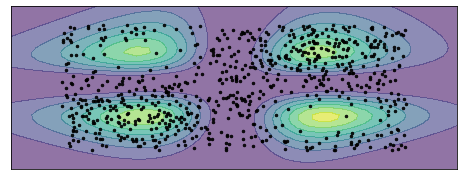

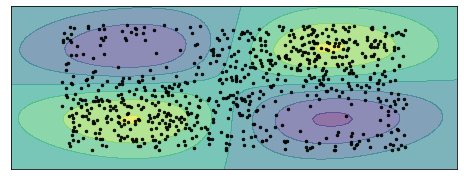

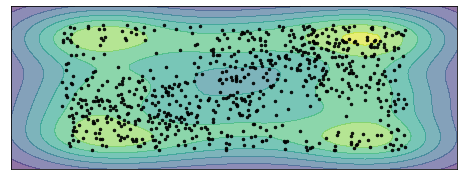

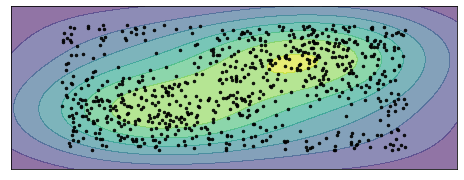

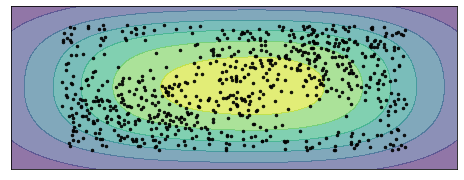

In [18]:
ps_sin = data.PS2DSinFreq(freq=1)
plot_locs_surface(ps_sin, n=1500, seed=33, fname_prefix='sin')

In [ ]:
def get_lin_psfunc():
    """
    Return a PairedSource to generate y = -x + Gaussian noise.
    """
    mean = 2
    width = 10
    px = lambda n: stats.uniform.rvs(loc=mean-width/2, scale=width, size=n)[:, np.newaxis]
    f = lambda x: -x + 0.3*np.random.randn(x.shape[0], 1)
    return data.PSFunc(f, px)

ps_lin = get_lin_psfunc()
plot_locs_surface(ps_lin, n=1000, seed=32, fname_prefix='lin')

In [ ]:
# paired source 
alpha = 0.01
n = 500
seed = 14

ps = get_quad_psfunc()
#ps = data.PSIndUnif(xlb=[0, 3], xub=[1, 10], ylb=[-5, 5], yub=[8, 10])
plot_locs_surface(ps, n)

In [ ]:
dx = 1
dy = 1
ps_sg = data.PSIndSameGauss(dx, dy)
plot_locs_surface(ps_sg, n=400)

When $X$ and $Y$ are independent, the regions that maximize the objective keep changing arbitrarily with $n$.

In [ ]:
def get_sin_psfunc(freq = 1/3.0):
    """
    Return a PairedSource to generate y = sin(x*f) + Gaussian noise.
    """
    px = lambda n: np.random.randn(n, 1)*8
    f = lambda x: np.sin(freq*x) + 0.1*np.random.randn(x.shape[0], 1)
    return data.PSFunc(f, px)

ps_sin = get_sin_psfunc()
plot_locs_surface(ps_sin, n=600)


This is the first example where the regions with high objective values keep moving as $n$ changes, even when $X$ and $Y$ are dependent. The test fails to reject $H_0$. It seems the test does not like a dependency given by a periodic function. **Update**: the test can handle it if the frequency is not too high.

In [ ]:
ps_rotate = data.PS2DUnifRotate(angle=np.pi*(1.0/4), xlb=-1, xub=1, ylb=-1, yub=1)
plot_locs_surface(ps_rotate, n=800)

In [ ]:
rot_data = ps_rotate.sample(3000, seed=3)
x, y = rot_data.xy()
plt.hist(x)